In [63]:
import hashlib
import re
import requests
import json
from datetime import date
import datetime
from dateutil.relativedelta import relativedelta
from html.parser import HTMLParser
from os import path
import matplotlib.pyplot as plt
import pandas as pd
from pandas import DataFrame as df
import numpy as np

In [19]:
# update me
url = "http://104.154.54.203/db_default/v4/nts/graph?highlight_run=145241&plot.1605785=1364.1605785.3"
filename = str(int(hashlib.sha256(url.encode('utf-8')).hexdigest()[:16],
                  16)-2**63) + ".txt"
print("cached filename:", filename)

if not path.exists(filename):
    payload = {}

    response = requests.request("GET", url, data=payload)

    with open(filename, "w") as f:
        f.write(response.text)


cached filename: -4690202479203809675.txt


In [20]:
class MyHTMLParser(HTMLParser):
    js_encountered = False

    def handle_starttag(self, tag, attrs):
        if tag != "script" or attrs != [('type', 'text/javascript')]:
            return
        self.js_encountered = True
        print("Encountered a start tag:", tag, attrs)

    def handle_endtag(self, tag):
        if not self.js_encountered:
            return
        print("Encountered an end tag :", tag)

    def handle_data(self, data):
        if not self.js_encountered:
            return
        self.js_encountered = False
        print("Encountered some data  :", data)
        print(data)
        print(data.index("graph_plots"))




In [121]:
def filter_by_date(points):
    one_month = date.today() - relativedelta(days=7)
    one_month = datetime.datetime(one_month.year, one_month.month, one_month.day)
    return [p for p in points if p[2] > one_month]

In [122]:
with open(filename, "r") as f:
    # parser = MyHTMLParser()
    # parser.feed(f.read())
    for line in f:
        if "overview_plots" in line:
            line = line.strip()
            # print(line)
            values = re.findall(r'var.*?=\s*(.*?);', line, re.DOTALL |
                                re.MULTILINE)
            # print((values[0][:10]))
            points = json.loads(values[0])
            points = points[0]["data"]  # a list of data points
            
            # convert string dates to manipulatable datetimes
            for p in points:
                p[2]["date"] = datetime.datetime.strptime(p[2]["date"], '%Y-%m-%d %H:%M:%S')
                p.insert(2, p[2]["date"])
                del p[3]["date"]

            points_df = pd.DataFrame(points,columns=["sequence", "execution time", "date", "metadata"])  # points_df is a dataframe
            display(points_df)
            
            points_1_week = filter_by_date(points)
#             print(len(points))
            
            print(points_1_week[0])
            print(points_1_week[1])
            print(points_1_week[2])
            print("...", len(points_1_week), "points found ...")
            break

,sequence,execution time,date,metadata
0,0,16.9392,2020-05-21 23:46:30,{'label': 'b0a0f01bc175b4c444052f871a89421889f...
1,1,17.2002,2021-01-16 12:19:38,{'label': 'f0a0ec2d085b0bc53e20643b740b20b49cf...
2,2,17.5059,2020-03-16 06:56:22,{'label': 'e0ab0e6a281f75e33090ed7f382a5f5e553...
3,3,16.6292,2021-03-24 11:12:45,{'label': 'cd0c00c9fe39a5dff9c776e5727fdf38be7...
4,4,16.4643,2021-03-04 04:50:47,{'label': 'a0ff0f30dfca8c9a5e3de3a82abfdbf097a...
...,...,...,...,...
9082,9082,16.7038,2021-04-08 07:46:28,{'label': 'df2578779778906438d7cb8f84ead414ae9...
9083,9083,17.0910,2020-07-26 14:20:46,{'label': '5819159995657091e4e21e538509b2af210...
9084,9084,17.2836,2020-04-25 20:04:55,{'label': '44257513173427550a882ad040e3e96bd2d...
9085,9085,16.6787,2021-05-21 15:12:55,{'label': '445680593889199667d60207e302bc870f6...


[78, 16.5015, datetime.datetime(2021, 5, 28, 14, 21, 43), {'label': '0c4f76c9421a9a72a9c86321628abcb31881ae94', 'runID': '145958'}]
[80, 16.7174, datetime.datetime(2021, 5, 27, 21, 17, 31), {'label': '0e4cf807aeaf54a10e02176498a7df13ac722b37', 'runID': '145916'}]
[88, 16.6576, datetime.datetime(2021, 5, 27, 23, 3, 29), {'label': '0fa5aac292b8e1bafb00b55233c78466b06bc323', 'runID': '145922'}]
... 135 points found ...


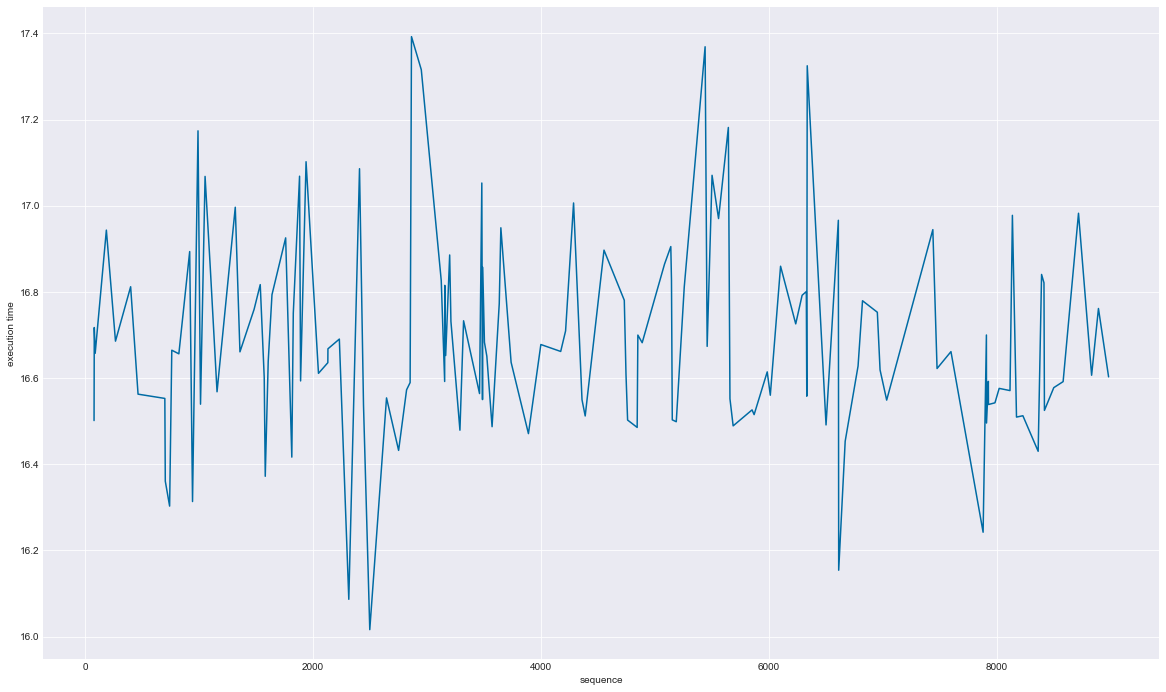

In [123]:
# points sort by sequence number
fig = plt.figure(figsize=(20,12))
xs = [p[0] for p in points_1_week]
ys = [p[1] for p in points_1_week]

plt.plot(xs, ys)
plt.xlabel('sequence')
plt.ylabel('execution time')
plt.grid(True)

plt.show()

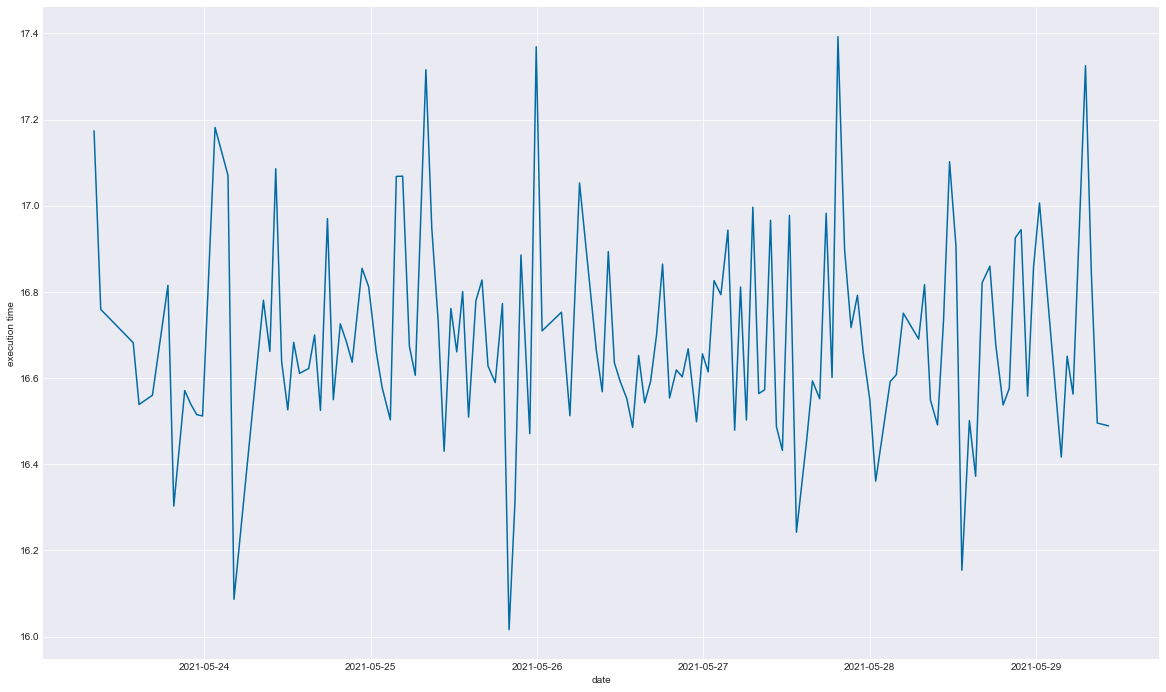

In [127]:
# points sort by dates
points_1_week.sort(key=lambda p: p[2])
dates = [p[2] for p in points_1_week]
ys = [p[1] for p in points_1_week]

fig = plt.figure(figsize=(20,12))
plt.plot(dates, ys)
plt.xlabel('date')
plt.ylabel('execution time')
plt.grid(True)

plt.show()

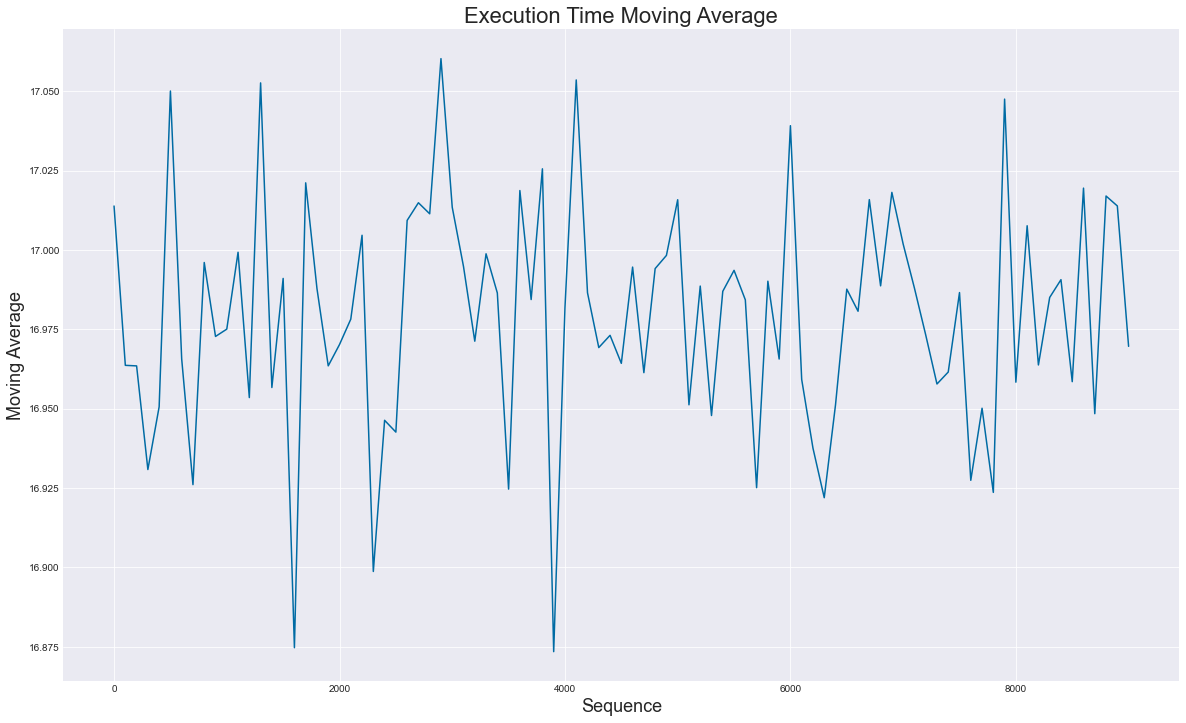

In [115]:
ma_100 = points_df["execution time"].groupby(np.arange(len(points_df))//100).mean()
plt.style.use('seaborn-dark')
plt.style.use("tableau-colorblind10")

fig = plt.figure(figsize=(20,12))
ax1 = plt.plot([100*i for i in range(len(ma_100))], ma_100)
ax1 = plt.title("Execution Time Moving Average", fontsize=22)
ax1 = plt.xlabel("Sequence", fontsize=18)
ax1 = plt.ylabel("Moving Average", fontsize=18)
# ax1 = plt.legend(["100 day SMA"],prop={"size":20}, loc="upper left")
plt.grid(True)
plt.show()

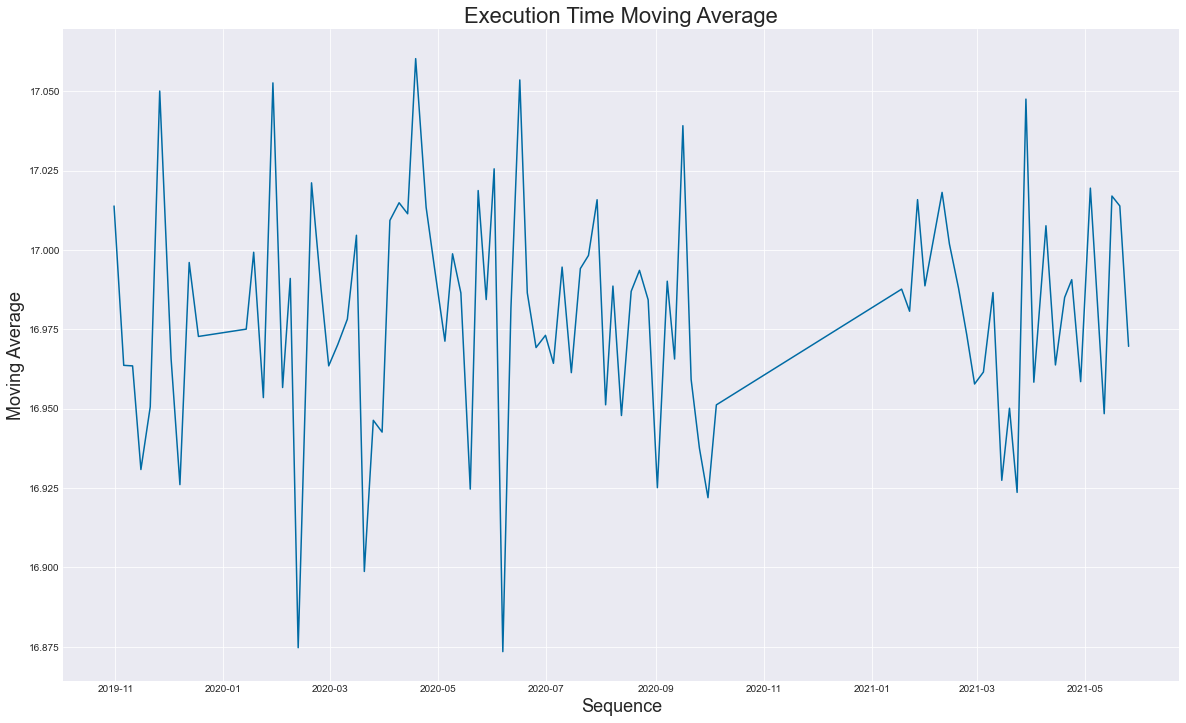

In [128]:
points_by_time_df = points_df.sort_values(by=['date'])

ma_100 = points_df["execution time"].groupby(np.arange(len(points_df))//100).mean()
plt.style.use('seaborn-dark')
plt.style.use("tableau-colorblind10")

fig = plt.figure(figsize=(20,12))
ax1 = plt.plot(points_by_time_df["date"].iloc[::100], ma_100)
ax1 = plt.title("Execution Time Moving Average", fontsize=22)
ax1 = plt.xlabel("Sequence", fontsize=18)
ax1 = plt.ylabel("Moving Average", fontsize=18)
# ax1 = plt.legend(["100 day SMA"],prop={"size":20}, loc="upper left")
plt.grid(True)
plt.show()